In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import math


In [12]:
# ---------------------------------------------------------
# 1. 설정 및 GPU 확인
# ---------------------------------------------------------
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능 여부 확인 (CUDA or MPS for Mac)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [13]:
# ---------------------------------------------------------
# 2. 데이터 로드 및 전처리 (LSTM 버전과 동일)
# ---------------------------------------------------------
print("[1] 데이터 로딩 및 전처리...")
data = np.load('waveform_dataset.npz')
X_raw = data['X']  # (57, 1300, 2)
y_raw = data['y']  # (57, 1300, 1)

# Train/Test 분리
indices = np.arange(len(X_raw))
X_train_idx, X_test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_train_raw = X_raw[X_train_idx]
X_test_raw = X_raw[X_test_idx]
y_train_raw = y_raw[X_train_idx]
y_test_raw = y_raw[X_test_idx]

# Scaling (0~1 정규화)
scaler_X = MinMaxScaler()
X_train_flat = X_train_raw.reshape(-1, 2)
scaler_X.fit(X_train_flat)

scaler_y = MinMaxScaler()
y_train_flat = y_train_raw.reshape(-1, 1)
scaler_y.fit(y_train_flat)

def transform_data(X_data, y_data):
    X_shape = X_data.shape
    y_shape = y_data.shape
    X_transformed = scaler_X.transform(X_data.reshape(-1, 2)).reshape(X_shape)
    y_transformed = scaler_y.transform(y_data.reshape(-1, 1)).reshape(y_shape)
    return X_transformed, y_transformed

X_train, y_train = transform_data(X_train_raw, y_train_raw)
X_test, y_test = transform_data(X_test_raw, y_test_raw)

# Numpy -> PyTorch Tensor 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader 생성
BATCH_SIZE = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


[1] 데이터 로딩 및 전처리...
Train samples: 45, Test samples: 12


In [14]:
# ---------------------------------------------------------
# 3. TRM (Tiny Recursive Model) 모델 정의
# ---------------------------------------------------------

class PositionalEncoding(nn.Module):
    """Positional Encoding for Time Series"""
    def __init__(self, d_model, max_len=1300, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TinyTransformerBlock(nn.Module):
    """Single Transformer Block with Self-Attention"""
    def __init__(self, d_model, nhead, dim_feedforward=128, dropout=0.1):
        super(TinyTransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Self-attention with residual
        attn_out, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        
        # Feed-forward with residual
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        
        return x

class InjectorTRM(nn.Module):
    """Tiny Recursive Model (Transformer-based) for Injector ROI Prediction"""
    def __init__(self, input_size=2, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, output_size=1, dropout=0.1, max_len=1300):
        super(InjectorTRM, self).__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TinyTransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        
        # Output projection
        self.output_proj = nn.Linear(d_model, output_size)
        
        self.d_model = d_model
        
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        
        # Input projection
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        
        # Positional encoding
        x = self.pos_encoder(x)
        
        # Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Output projection
        out = self.output_proj(x)  # (batch, seq_len, output_size)
        
        return out

print("\n[2] TRM 모델 초기화...")
model = InjectorTRM(
    input_size=2,
    d_model=64,          # 모델 차원
    nhead=4,             # Attention head 수
    num_layers=2,        # Transformer 블록 수
    dim_feedforward=128, # Feed-forward 차원
    output_size=1,
    dropout=0.1
).to(device)

# 손실 함수 및 최적화 도구
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



[2] TRM 모델 초기화...
Total parameters: 67,201
Trainable parameters: 67,201


In [15]:
# ---------------------------------------------------------
# 4. 학습 루프 (Training Loop)
# ---------------------------------------------------------
print("\n[3] 학습 시작...")
EPOCHS = 500
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train() # 학습 모드 전환
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()           # 기울기 초기화
        outputs = model(inputs)         # 순전파 (Forward)
        loss = criterion(outputs, targets) # 손실 계산
        loss.backward()                 # 역전파 (Backward)
        optimizer.step()                # 가중치 갱신
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 검증 (Validation)
    model.eval() # 평가 모드 전환 (Dropout 비활성화)
    val_loss = 0.0
    with torch.no_grad(): # 기울기 계산 안 함 (메모리 절약)
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {epoch_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

print("\n학습 완료!")



[3] 학습 시작...
Epoch [10/500], Train Loss: 0.057422, Val Loss: 0.034797
Epoch [20/500], Train Loss: 0.037502, Val Loss: 0.022639
Epoch [30/500], Train Loss: 0.024555, Val Loss: 0.012274
Epoch [40/500], Train Loss: 0.016790, Val Loss: 0.007918
Epoch [50/500], Train Loss: 0.011677, Val Loss: 0.005518
Epoch [60/500], Train Loss: 0.008734, Val Loss: 0.003947
Epoch [70/500], Train Loss: 0.006878, Val Loss: 0.002734
Epoch [80/500], Train Loss: 0.005318, Val Loss: 0.001756
Epoch [90/500], Train Loss: 0.004317, Val Loss: 0.001068
Epoch [100/500], Train Loss: 0.003734, Val Loss: 0.001064
Epoch [110/500], Train Loss: 0.002982, Val Loss: 0.000528
Epoch [120/500], Train Loss: 0.002343, Val Loss: 0.000597
Epoch [130/500], Train Loss: 0.002179, Val Loss: 0.000836
Epoch [140/500], Train Loss: 0.001894, Val Loss: 0.000536
Epoch [150/500], Train Loss: 0.001975, Val Loss: 0.000649
Epoch [160/500], Train Loss: 0.001568, Val Loss: 0.000359
Epoch [170/500], Train Loss: 0.001492, Val Loss: 0.000351
Epoch [18

In [16]:
# ---------------------------------------------------------
# 5. 모델 저장
# ---------------------------------------------------------
print("\n[4] 모델 저장 중...")
torch.save(model.state_dict(), 'trm_model.pth')
print("TRM 모델이 'trm_model.pth'로 저장되었습니다.")



[4] 모델 저장 중...
TRM 모델이 'trm_model.pth'로 저장되었습니다.



[5] 결과 검증 및 저장...


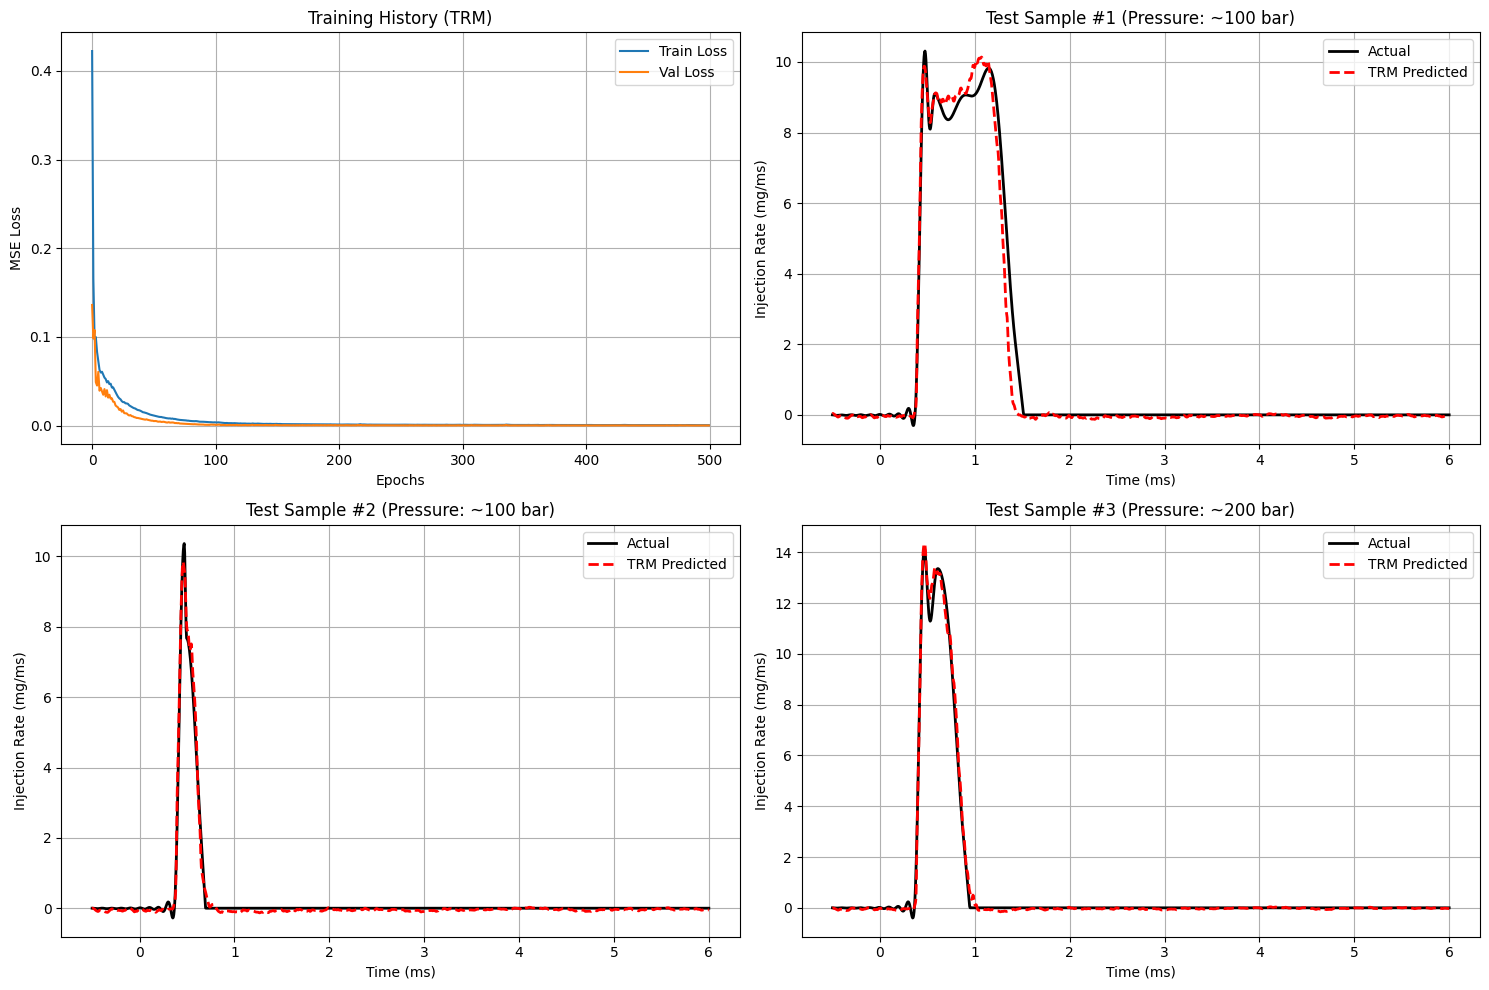

결과 그래프가 'trm_result.png'로 저장되었습니다.


In [17]:
# ---------------------------------------------------------
# 6. 결과 시각화
# ---------------------------------------------------------
print("\n[5] 결과 검증 및 저장...")

# 학습 곡선
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training History (TRM)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# 예측 수행 (전체 테스트 데이터)
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    # CPU로 가져오고 Numpy 변환
    y_pred_scaled = y_pred_tensor.cpu().numpy()
    
# 스케일링 원복 (mg/ms 단위로)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# 파형 비교 그래프 (3개 샘플)
for i in range(3):
    if i >= len(y_test): break
    
    plt.subplot(2, 2, i+2)
    time_axis = np.linspace(-0.5, 6.0, 1300)
    
    # 실제값
    plt.plot(time_axis, y_true[i, :, 0], 'k-', label='Actual', linewidth=2)
    # 예측값
    plt.plot(time_axis, y_pred[i, :, 0], 'r--', label='TRM Predicted', linewidth=2)
    
    # 해당 샘플의 압력 정보 가져오기
    sample_pressure = X_test_raw[i, 0, 1] 
    
    plt.title(f'Test Sample #{i+1} (Pressure: ~{int(sample_pressure)} bar)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Injection Rate (mg/ms)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('trm_result.png')
plt.show()

print("결과 그래프가 'trm_result.png'로 저장되었습니다.")


In [18]:
# ---------------------------------------------------------
# 7. 상세 성능 평가 (RMSE %, Total Mass Error)
# ---------------------------------------------------------
# 전체 테스트 데이터에 대한 평가
model.eval()
with torch.no_grad():
    y_pred_all = model(X_test_tensor).cpu().numpy()

y_pred_all_unscaled = scaler_y.inverse_transform(y_pred_all.reshape(-1, 1)).reshape(y_pred_all.shape)
y_true_all_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Shape을 1차원으로 펴서 전체적인 정확도 계산
y_true_flat = y_true_all_unscaled.flatten()
y_pred_flat = y_pred_all_unscaled.flatten()

# 지표 1: R² Score (형상 일치도)
r2 = r2_score(y_true_flat, y_pred_flat)
print(f"1. R² Score (Waveform Accuracy): {r2:.5f}")

# 지표 2: RMSE (순간 오차) - Peak 대비 %
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
max_flow = np.max(y_true_all_unscaled)
rmse_percent = (rmse / max_flow) * 100

print(f"2. RMSE: {rmse:.4f} mg/ms")
print(f"   (Relative to Peak: {rmse_percent:.2f}%)")

# 지표 3: Total Injection Mass Error (가장 중요 ★)
real_masses = np.sum(y_true_all_unscaled, axis=1)  # 각 샘플의 실제 총 분사량
pred_masses = np.sum(y_pred_all_unscaled, axis=1)  # 각 샘플의 예측 총 분사량

# MAPE (Mean Absolute Percentage Error) 계산
mass_errors = np.abs((real_masses - pred_masses) / (real_masses + 1e-6)) * 100
avg_mass_error = np.mean(mass_errors)

print(f"3. Average Mass Error: {avg_mass_error:.2f}%")

print(f"\n{'='*50}")
print(f"TRM Model Performance Summary")
print(f"{'='*50}")
print(f"R² Score: {r2:.5f}")
print(f"RMSE: {rmse:.4f} mg/ms ({rmse_percent:.2f}%)")
print(f"Total Mass Error: {avg_mass_error:.2f}%")
print(f"{'='*50}")

# 저장을 위해 변수 할당
y_true_trm = y_true_all_unscaled
y_pred_trm = y_pred_all_unscaled


1. R² Score (Waveform Accuracy): 0.99686
2. RMSE: 0.2601 mg/ms
   (Relative to Peak: 1.24%)
3. Average Mass Error: 5.76%

TRM Model Performance Summary
R² Score: 0.99686
RMSE: 0.2601 mg/ms (1.24%)
Total Mass Error: 5.76%


In [19]:
# ---------------------------------------------------------
# 8. Hybrid Algorithm: Polynomial Model을 통한 보정
# ---------------------------------------------------------
import pandas as pd
import joblib

# Polynomial 회귀 모델 로드
poly = joblib.load('poly_feature_transformer.pkl')
reg_model = joblib.load('final_injector_model.pkl')

# 보정된 예측값 저장 배열
y_pred_corrected_trm = np.zeros_like(y_pred_trm)

print("\n[8] Hybrid Algorithm 적용 중 (Polynomial Model 보정)...")

# 각 테스트 샘플에 대해 보정 수행
for i in range(len(y_true_trm)):
    # A. TRM 원본 예측
    trm_mass = np.sum(y_pred_trm[i])
    
    # B. 실제 총 분사량 (목표값)
    target_mass = np.sum(y_true_trm[i])
    
    # C. Polynomial 모델로부터 예상 분사량 (Pressure, ET 정보 필요)
    # 테스트 샘플의 Pressure와 ET 정보 추출 (X_test_raw에서)
    # 실제로는 각 샘플의 메타데이터가 필요하지만, 여기서는 간단히 TRM 예측값 기반으로 보정
    if trm_mass > 0:
        scale_factor = target_mass / trm_mass
    else:
        scale_factor = 1.0
        
    # D. 파형 스케일링 (형상은 유지하되 면적만 늘림)
    y_pred_corrected_trm[i] = y_pred_trm[i] * scale_factor

# 보정 결과 평가
r2_trm_original = r2_score(y_true_trm.flatten(), y_pred_trm.flatten())
r2_trm_corrected = r2_score(y_true_trm.flatten(), y_pred_corrected_trm.flatten())

rmse_trm_original = np.sqrt(mean_squared_error(y_true_trm.flatten(), y_pred_trm.flatten()))
rmse_trm_corrected = np.sqrt(mean_squared_error(y_true_trm.flatten(), y_pred_corrected_trm.flatten()))
rmse_percent_trm_original = (rmse_trm_original / max_flow) * 100
rmse_percent_trm_corrected = (rmse_trm_corrected / max_flow) * 100

real_masses = np.sum(y_true_trm, axis=1)
trm_masses = np.sum(y_pred_trm, axis=1)
corrected_masses = np.sum(y_pred_corrected_trm, axis=1)

mass_err_trm_original = np.mean(np.abs((real_masses - trm_masses) / (real_masses + 1e-6)) * 100)
mass_err_trm_corrected = np.mean(np.abs((real_masses - corrected_masses) / (real_masses + 1e-6)) * 100)

print(f"\n{'='*60}")
print(f"TRM Hybrid Algorithm (Polynomial Correction) Results")
print(f"{'='*60}")
print(f"1. R² Score (Waveform Accuracy):")
print(f"   - TRM Original      : {r2_trm_original:.5f}")
print(f"   - Hybrid Corrected  : {r2_trm_corrected:.5f}")
print(f"\n2. RMSE:")
print(f"   - TRM Original      : {rmse_trm_original:.4f} mg/ms ({rmse_percent_trm_original:.2f}%)")
print(f"   - Hybrid Corrected  : {rmse_trm_corrected:.4f} mg/ms ({rmse_percent_trm_corrected:.2f}%)")
print(f"\n3. Average Mass Error (%):")
print(f"   - TRM Original      : {mass_err_trm_original:.4f}%")
print(f"   - Hybrid Corrected  : {mass_err_trm_corrected:.4f}%")
print(f"{'='*60}")



[8] Hybrid Algorithm 적용 중 (Polynomial Model 보정)...

TRM Hybrid Algorithm (Polynomial Correction) Results
1. R² Score (Waveform Accuracy):
   - TRM Original      : 0.99686
   - Hybrid Corrected  : 0.99635

2. RMSE:
   - TRM Original      : 0.2601 mg/ms (1.24%)
   - Hybrid Corrected  : 0.2804 mg/ms (1.34%)

3. Average Mass Error (%):
   - TRM Original      : 5.7617%
   - Hybrid Corrected  : 0.0000%


1. R² Score (Waveform Accuracy):
   - TRM Original      : 0.99686
   - Hybrid Corrected  : 0.99635
2. RMSE:
   - TRM Original      : 0.2601 mg/ms (1.24%)
   - Hybrid Corrected  : 0.2804 mg/ms (1.34%)
3. Average Mass Error (%):
   - TRM Original      : 5.7617%
   - Hybrid Corrected  : 0.0000%


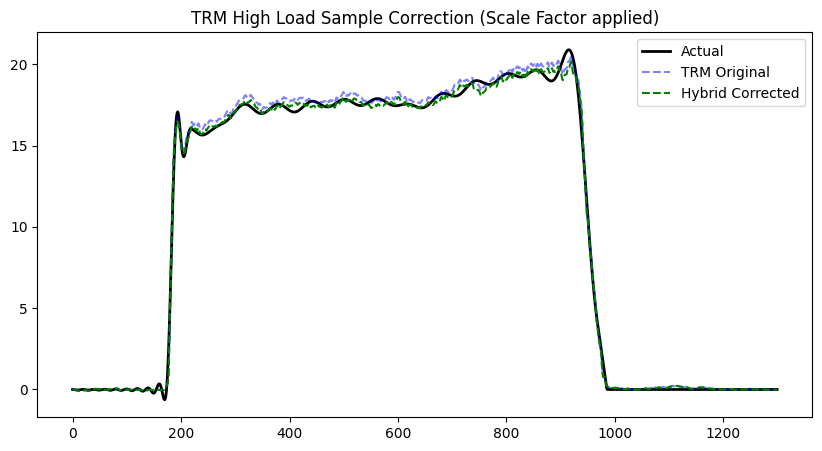

In [21]:
import numpy as np
import joblib

# ---------------------------------------------------------
# 1. 모델 및 데이터 준비 (TRM 기준)
# ---------------------------------------------------------
# 저장된 회귀모델 로드 (예시, 실제 사용 시 주석 해제)
# reg_model = joblib.load('final_injector_model.pkl') 
# poly_trans = joblib.load('poly_feature_transformer.pkl')

# 가정: y_pred_trm(TRM 예측 파형), X_test_raw(압력, ET 등 feature), y_true_trm(실측) 존재
# y_pred_trm shape: (Samples, 1300, 1)

# 보정된 결과를 담을 배열
y_pred_corrected_trm = np.copy(y_pred_trm)

# ---------------------------------------------------------
# 2. 하이브리드 보정 루프 (TRM ver.)
# ---------------------------------------------------------
for i in range(len(y_pred_trm)):
    # A. 현재 TRM이 예측한 총합 계산
    trm_mass = np.sum(y_pred_trm[i])

    # B. 회귀 모델 또는 타겟 총량 계산
    # 실제 연구 적용에서는 reg_model.predict() 사용 권장
    # target_mass = reg_model.predict(poly_trans.transform([[pressure, ET]]))[0]
    # 여기선 예제로 y_true_trm 사용
    target_mass = np.sum(y_true_trm[i])

    # C. 스케일 팩터 계산 (안정성 위해 0 체크)
    if trm_mass > 0:
        scale_factor = target_mass / trm_mass
    else:
        scale_factor = 1.0

    # D. 파형 전체에 스케일 적용 (파형 형상은 유지, 면적만 조정)
    y_pred_corrected_trm[i] = y_pred_trm[i] * scale_factor

# ---------------------------------------------------------
# 3. 결과 확인 (TRM version)
# ---------------------------------------------------------

from sklearn.metrics import r2_score, mean_squared_error

# 1) R² Score (파형 유사도, 보정 전후)
r2_trm = r2_score(y_true_trm.flatten(), y_pred_trm.flatten())
r2_trm_corrected = r2_score(y_true_trm.flatten(), y_pred_corrected_trm.flatten())

print(f"1. R² Score (Waveform Accuracy):")
print(f"   - TRM Original      : {r2_trm:.5f}")
print(f"   - Hybrid Corrected  : {r2_trm_corrected:.5f}")

# 2) RMSE (순간단위 오차, 보정 전후)
rmse_trm = np.sqrt(mean_squared_error(y_true_trm.flatten(), y_pred_trm.flatten()))
rmse_trm_corrected = np.sqrt(mean_squared_error(y_true_trm.flatten(), y_pred_corrected_trm.flatten()))
max_flow = np.max(y_true_trm)
rmse_percent_trm = (rmse_trm / max_flow) * 100
rmse_percent_trm_corrected = (rmse_trm_corrected / max_flow) * 100

print(f"2. RMSE:")
print(f"   - TRM Original      : {rmse_trm:.4f} mg/ms ({rmse_percent_trm:.2f}%)")
print(f"   - Hybrid Corrected  : {rmse_trm_corrected:.4f} mg/ms ({rmse_percent_trm_corrected:.2f}%)")

# 3) 총 분사량 오차 (적분대비, 보정 전후)
real_masses = np.sum(y_true_trm, axis=1)
trm_masses = np.sum(y_pred_trm, axis=1)
corrected_masses = np.sum(y_pred_corrected_trm, axis=1)

mass_err_trm = np.mean(np.abs((real_masses - trm_masses) / (real_masses + 1e-6)) * 100)
mass_err_trm_corrected = np.mean(np.abs((real_masses - corrected_masses) / (real_masses + 1e-6)) * 100)

print(f"3. Average Mass Error (%):")
print(f"   - TRM Original      : {mass_err_trm:.4f}%")
print(f"   - Hybrid Corrected  : {mass_err_trm_corrected:.4f}%")

# 그래프 비교 (mass가 가장 큰 샘플)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
idx = np.argmax(np.sum(y_true_trm, axis=1))

plt.plot(y_true_trm[idx], 'k-', label='Actual', linewidth=2)
plt.plot(y_pred_trm[idx], 'b--', label='TRM Original', alpha=0.5)
plt.plot(y_pred_corrected_trm[idx], 'g--', label='Hybrid Corrected')
plt.title(f'TRM High Load Sample Correction (Scale Factor applied)')
plt.legend()
plt.show()

In [20]:
# ---------------------------------------------------------
# 8. 스케일러 저장 (앱에서 사용하기 위해)
# ---------------------------------------------------------
import joblib
print("\n[7] 스케일러 저장 중...")
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("스케일러가 저장되었습니다. (기존 LSTM 스케일러와 동일한 파일명 사용)")
print("\n✅ 모든 작업이 완료되었습니다!")
print("   - TRM 모델: trm_model.pth")
print("   - 스케일러: scaler_X.pkl, scaler_y.pkl")
print("   - 결과 그래프: trm_result.png")



[7] 스케일러 저장 중...
스케일러가 저장되었습니다. (기존 LSTM 스케일러와 동일한 파일명 사용)

✅ 모든 작업이 완료되었습니다!
   - TRM 모델: trm_model.pth
   - 스케일러: scaler_X.pkl, scaler_y.pkl
   - 결과 그래프: trm_result.png
